In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *

from pysptools.material_count.vd import HfcVd
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

from earthpy.spatial import bytescale

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

In [26]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_CUSouth_poi.shp"
gdf1 = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf1.crs))



point CRS: {'init': 'epsg:32613'}


In [27]:
gdf = gdf1.drop(1).reset_index()
gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

,index,Id,comments,geometry
0,0,0,dirt parking lot,POINT (-105.2320413087213 39.97927552633687)
1,2,0,tennis court (south),POINT (-105.2321048858712 39.97956622917603)
2,3,0,red hut,POINT (-105.2320315564236 39.9796903363637)
3,4,0,grass patch (south),POINT (-105.2319140238961 39.97865502556768)
4,5,0,leaf off tree,POINT (-105.2320006579609 39.97880026728588)


In [28]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
neon_radiance_file = data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/NEON_D10_V10C_DP1_20190409_221206_radiance.h5'

# headwall radiance files... these were built 'by hand' in ENVI
radiance_files_VNIR_april09 = glob('../headwall_data/raw/radiance/VNIR_CUSouth/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob('../headwall_data/raw/radiance/SWIR_CUSouth/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr

# construct the filename pairs with the block numbers
vs_pairs = [(0,0), (2000,2000), (4000,4000)]
hw_vs_pair_names = []
for p in vs_pairs:
    v_block, s_block = p
    v_file = [f for f in radiance_files_VNIR_april09 if f'block{v_block}' in f][0]
    s_file = [f for f in radiance_files_SWIR_april09 if f'block{s_block}' in f][0]
    hw_vs_pair_names.append((v_file, s_file))
    
hw_lbl = [f'HW-{v}-{s}' for v,s in vs_pairs]
hw_lbl

['HW-0-0', 'HW-2000-2000', 'HW-4000-4000']

In [85]:
hw_vs_pair_names

[('../headwall_data/raw/radiance/VNIR_CUSouth\\headwall_CUS_block0_vnir_rad_glt_cor',
  '../headwall_data/raw/radiance/SWIR_CUSouth\\headwall_CUS_block0_swir_rad_glt_cor'),
 ('../headwall_data/raw/radiance/VNIR_CUSouth\\headwall_CUS_block2000_vnir_rad_glt_cor',
  '../headwall_data/raw/radiance/SWIR_CUSouth\\headwall_CUS_block2000_swir_rad_glt_cor'),
 ('../headwall_data/raw/radiance/VNIR_CUSouth\\headwall_CUS_block4000_vnir_rad_glt_cor',
  '../headwall_data/raw/radiance/SWIR_CUSouth\\headwall_CUS_block4000_swir_rad_glt_cor')]

In [29]:
# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
reflectance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
reflectance_files_VNIR_april09 = [f[:-4] for f in reflectance_files_VNIR_april09] # remove the .hdr

reflectance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
reflectance_files_SWIR_april09 = [f[:-4] for f in reflectance_files_SWIR_april09] # remove the .hdr

In [30]:
data_file_NEON = neon_radiance_file

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)

NEON ID:  V10C


In [31]:
xarr_VNIR_ls, xarr_SWIR_ls, x_vnir_ls, y_vnir_ls, x_swir_ls, y_swir_ls = [], [], [], [], [], []

for data_file_VNIR, data_file_SWIR in hw_vs_pair_names:
    ## read the data into xarray datasets, chunk with Dask
    # first Headwall
    xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
    xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
    x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
    x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

    # in this case, need to extract out the wavelength information!
    band_vnir = xr.open_rasterio(reflectance_files_VNIR_april09[0]).coords['band']
    band_swir = xr.open_rasterio(reflectance_files_SWIR_april09[0]).coords['band']

    xarr_VNIR.coords['band'] = band_vnir
    xarr_SWIR.coords['band'] = band_swir
    
    # append to lists
    xarr_VNIR_ls.append(xarr_VNIR)
    x_vnir_ls.append(x_vnir)
    y_vnir_ls.append(y_vnir)
    
    # append to lists
    xarr_SWIR_ls.append(xarr_SWIR)
    x_swir_ls.append(x_swir)
    y_swir_ls.append(y_swir)

In [32]:
# then NEON (dask chunking done in-function)
x_neon, y_neon, xarr_NEON = NEON_create_rad_xarr_from_h5_file(data_file_NEON, nid=neon_id)



D:\projects\headwall_neon\notebooks\xarr_helpers.py:45: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_str = f[nid]['Radiance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:46: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_epsg = f[nid]['Radiance']['Metadata']['Coordinate_System']['EPSG Code'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_mapinfo = f[nid]['Radiance']['Metadata']['Coordinate_System']['Map_Info'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_proj4 = f[nid]['Radiance']['Metadata']['Coordinate_System']['Proj4'].value


In [33]:
xarr_NEON.shape

(13313, 903, 426)

In [34]:
# get a headwall dataset extent
XMIN, YMIN = -100, 40
XMAX, YMAX = -110, 30
for x,y in zip(x_vnir_ls, y_vnir_ls):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    
    if xmin < XMIN:
        XMIN = xmin
    if xmax > XMAX:
        XMAX = xmax
    if ymin < YMIN:
        YMIN = ymin
    if ymax > YMAX:
        YMAX = ymax

print(XMIN, YMIN, XMAX, YMAX)


-105.23220322 39.978184670000005 -105.23182768999999 39.97988237


In [35]:
# subset the NEON data with the full extent of headwall data cubes
from shapely.geometry import mapping, box

bbox = box(XMIN, YMIN, XMAX, YMAX)
chunk1 = gpd.GeoDataFrame({'geometry':[bbox]}, crs=fiona.crs.from_epsg(4326)).to_crs(epsg=32613)

neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
neon_wav, full_neon = neon_arrs

# Estimate number of materials present in scene

In [36]:
neon_shp = neon_sub_cube.values.shape
est_num_mats = HfcVd(neon_sub_cube.values.reshape(neon_shp[0]*neon_shp[1], neon_shp[2]), far='default')
est_num_mats

[185, 167, 153]

# Auto-Extract 3, 4, and 5 endmembers. Then plot their abundance maps.

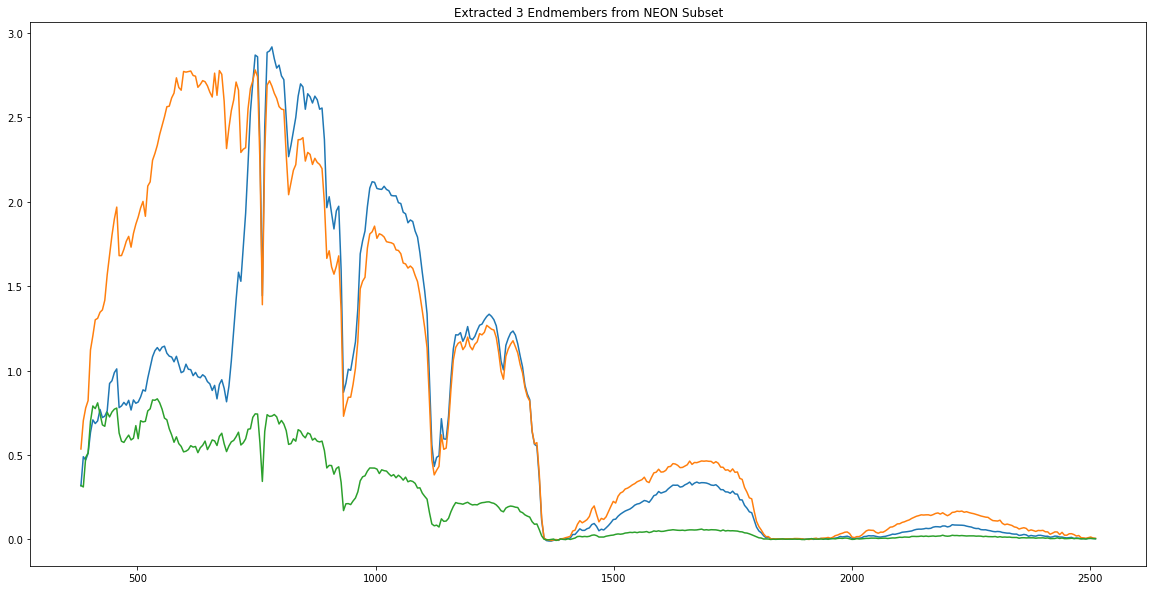

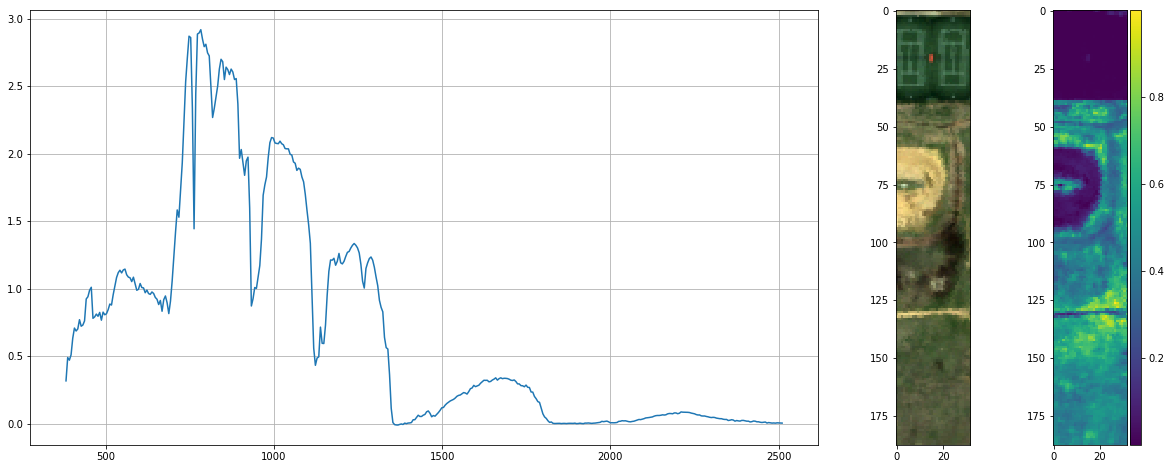

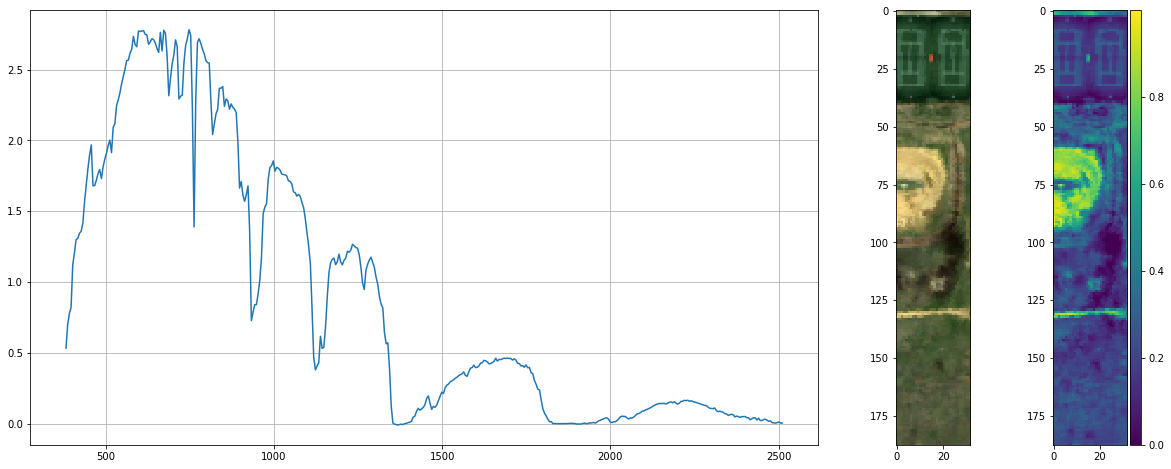

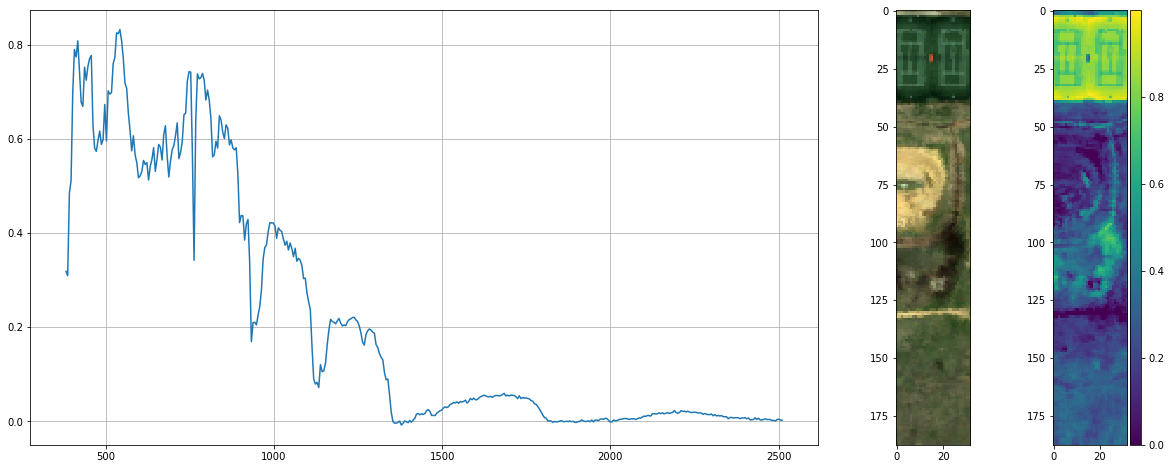

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


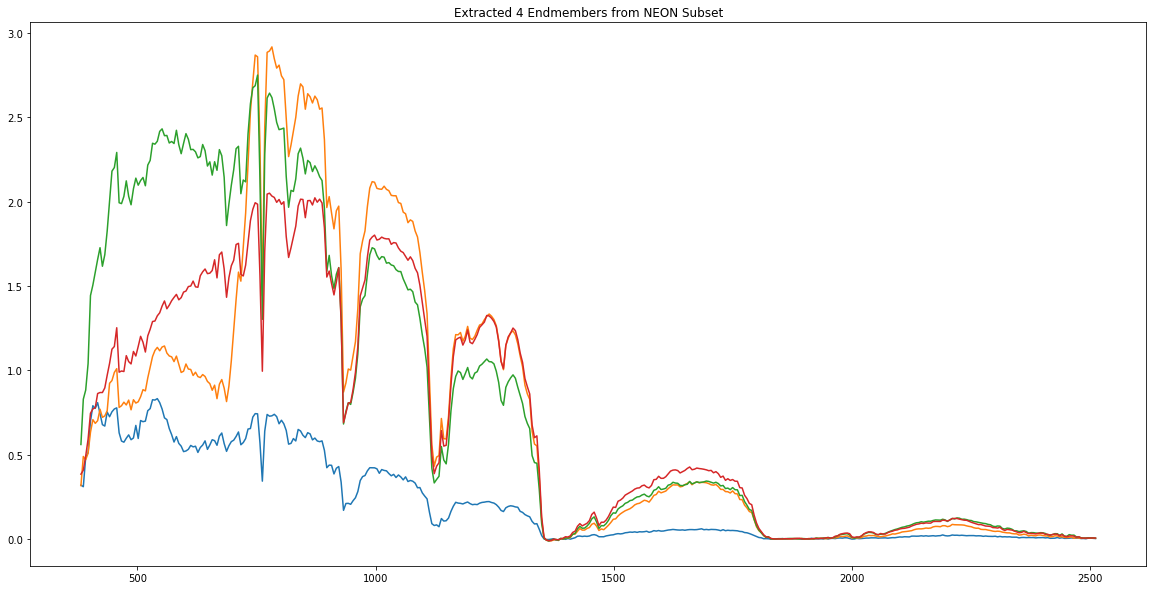

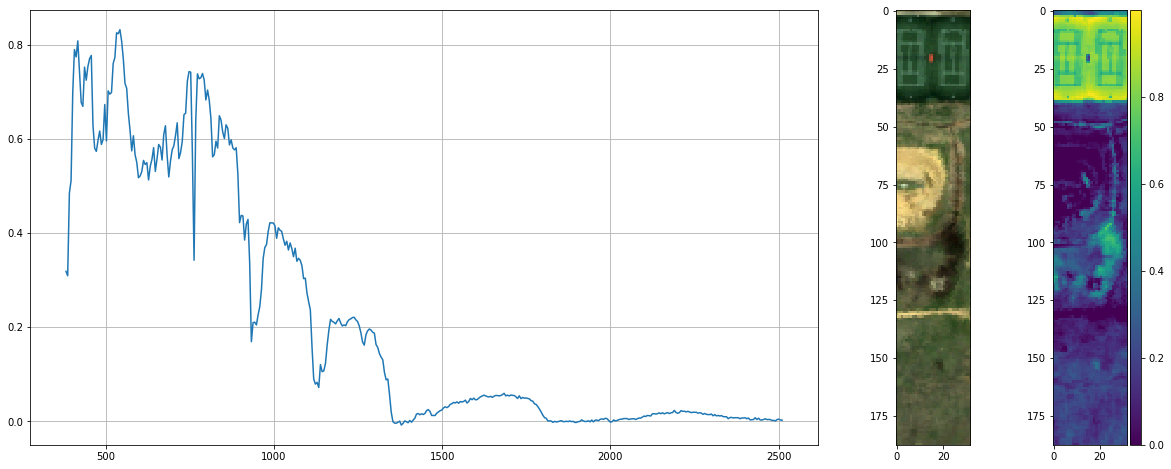

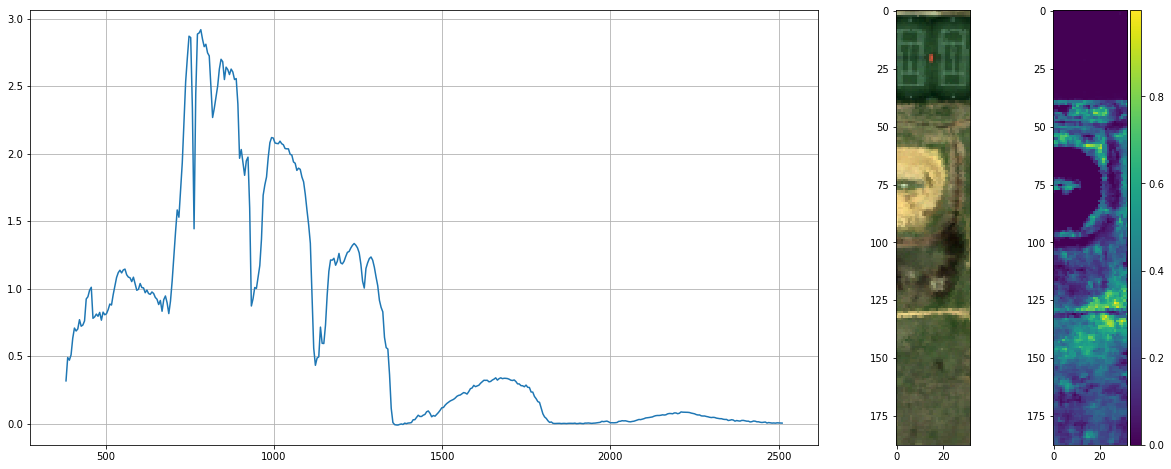

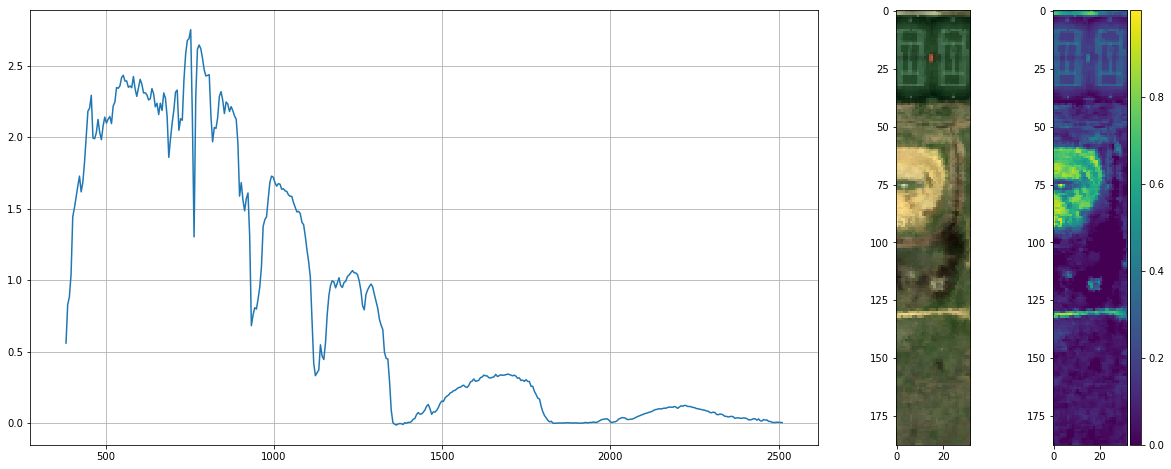

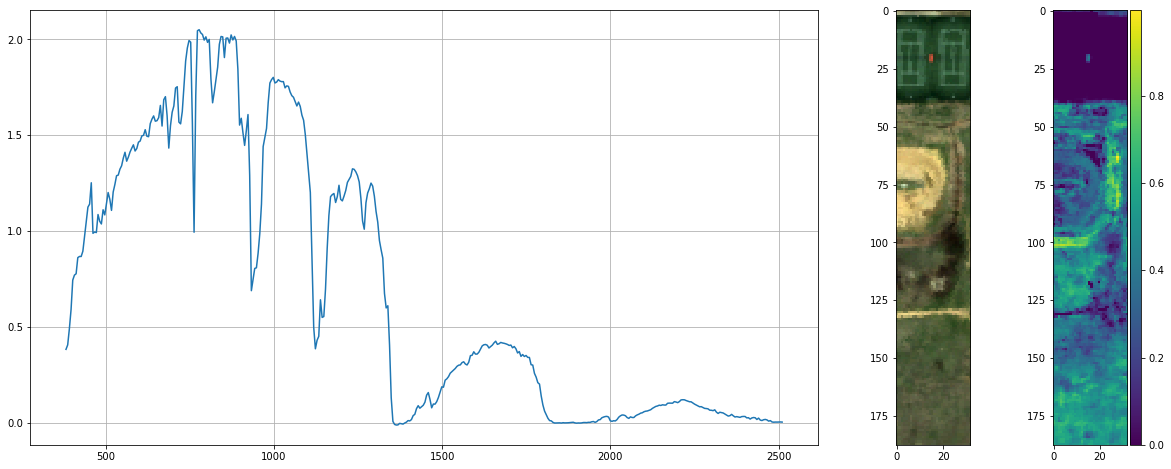

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


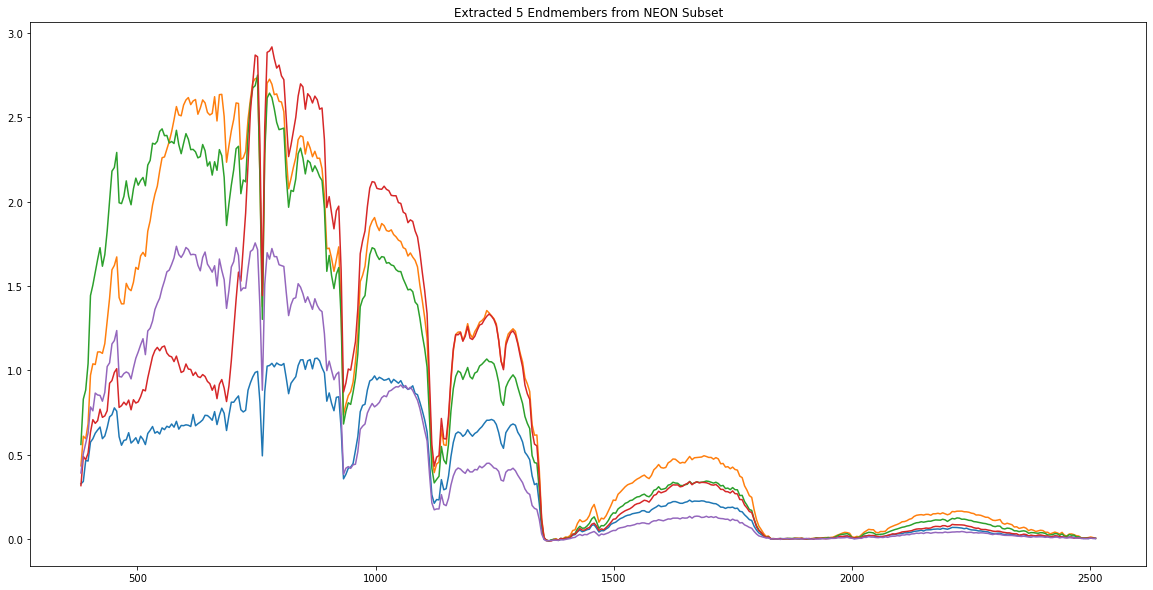

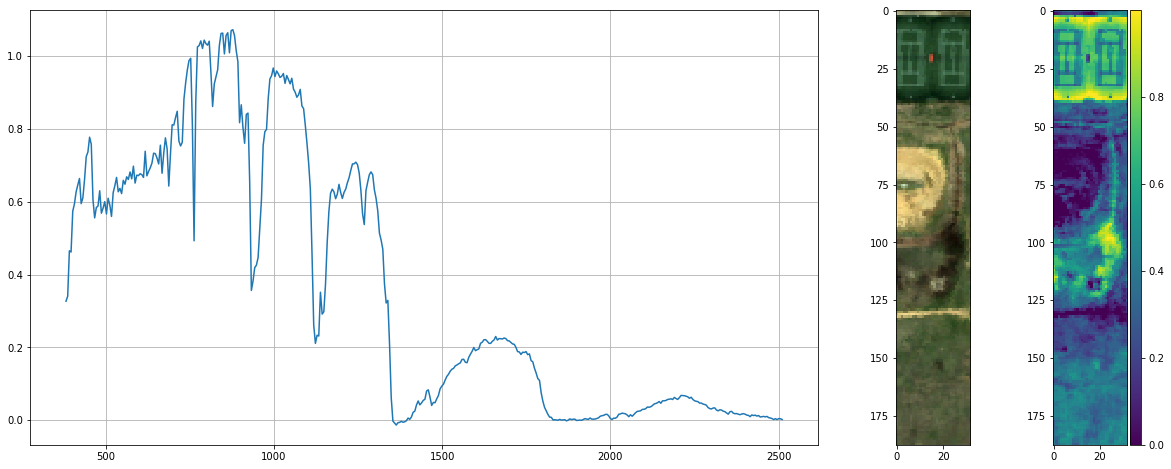

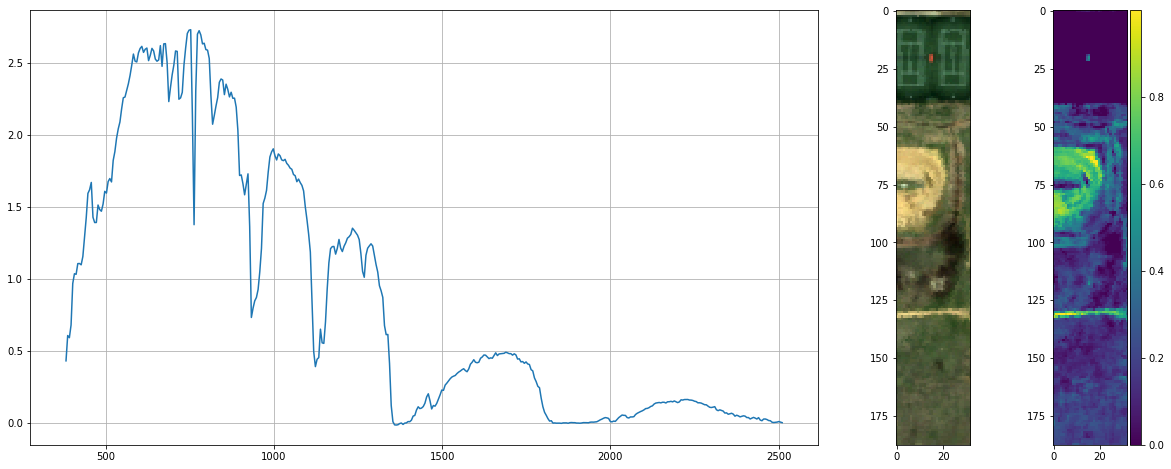

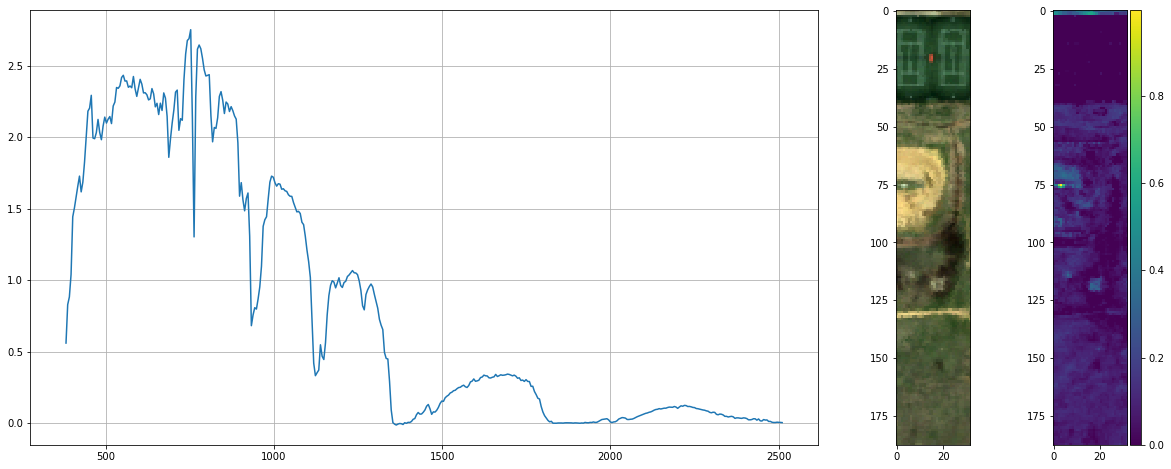

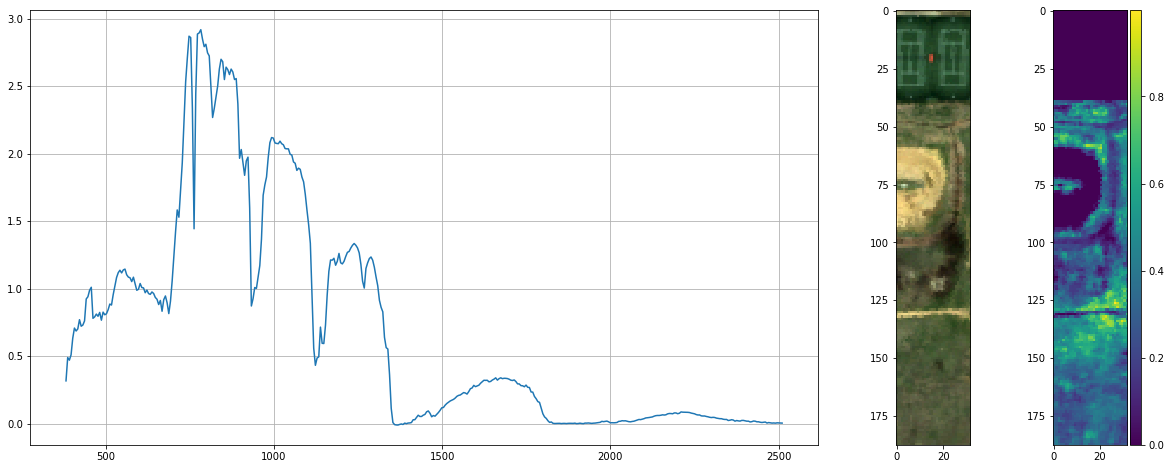

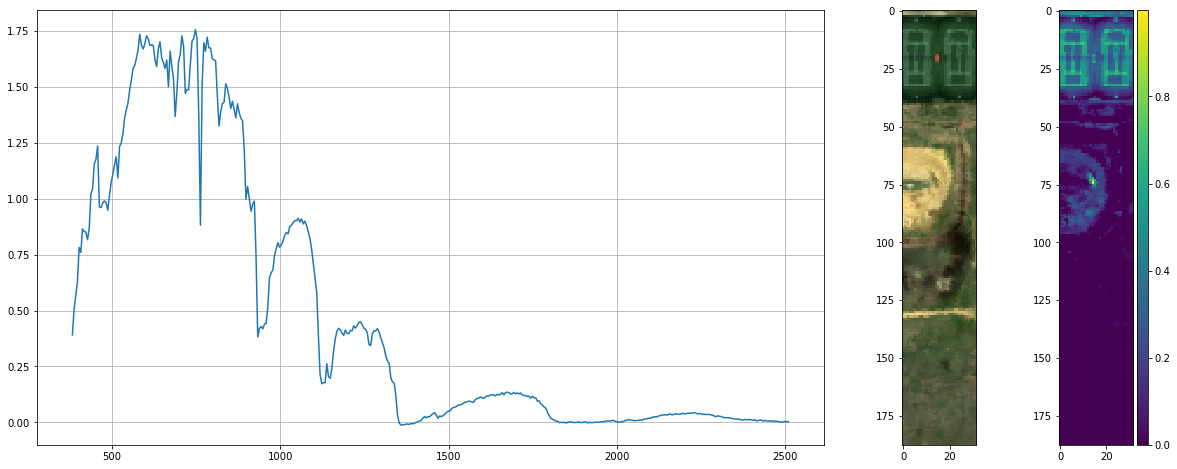

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [37]:
ee = eea.NFINDR()

for n_em in [3,4,5]:
    
    U = ee.extract(neon_sub_cube.values, n_em, maxit=10, normalize=False, ATGP_init=True)
    
    # plot them
    plt.figure(figsize=(20,10))
    for em in U:
        plt.plot(neon_wav, em)
        
    plt.title(f'Extracted {n_em} Endmembers from NEON Subset')
    plt.show()

    # Plot the abundance maps
    am = amap.FCLS()
    ab_maps = am.map(neon_sub_cube.values, U, normalize=False)
    
    for i,em in enumerate(U):
        fig = plt.figure(figsize=(20,8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[8, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        p0 = ax0.plot(neon_wav, em)
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

        ax2 = plt.subplot(gs[2])
        im2 = ax2.imshow(ab_maps[:,:,i])


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)

        plt.colorbar(im2, cax=cax)
        plt.show()
        
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')

# Use spatial extraction to generate the endmember spectra, and plot the abundance maps

In [38]:
neon_pt_em, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), gdf)
# neon_wav, full_neon = neon_arrs

neon_pt_em.shape

(5, 4, 426)

In [39]:
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(np.squeeze(ex_neon))

neon_pt_em = np.vstack(temp)
neon_pt_em.shape

(5, 426)

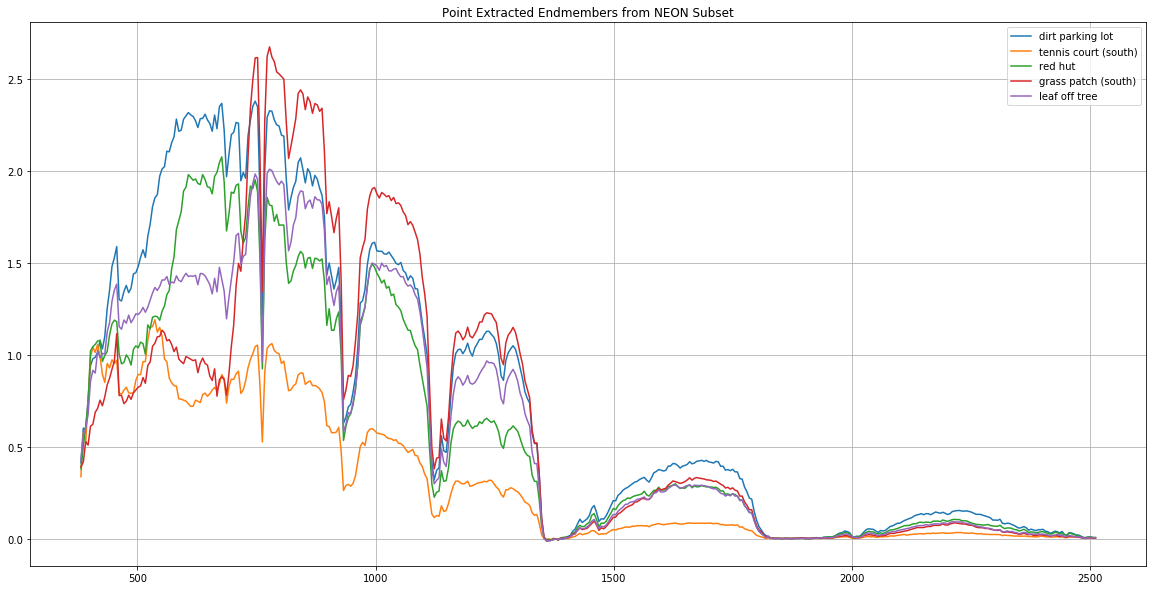

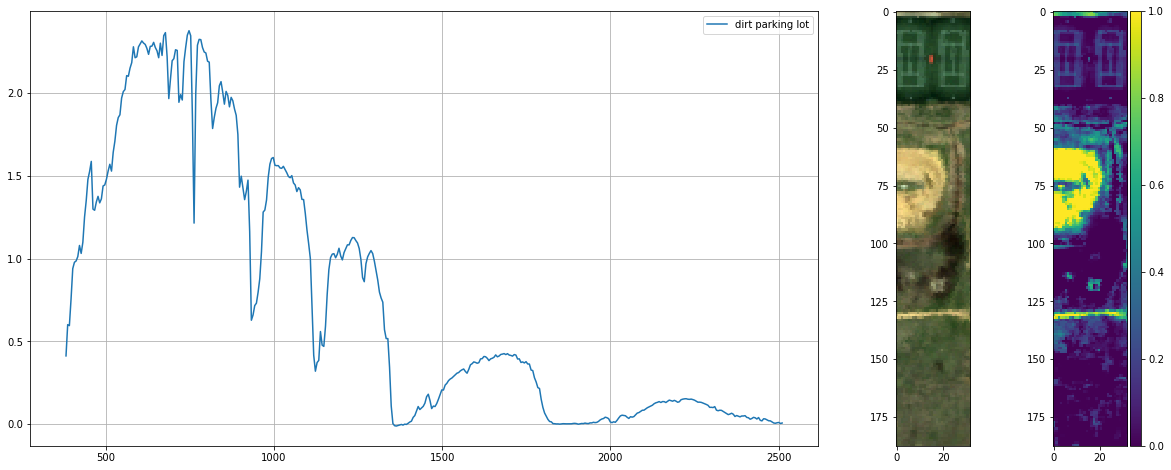

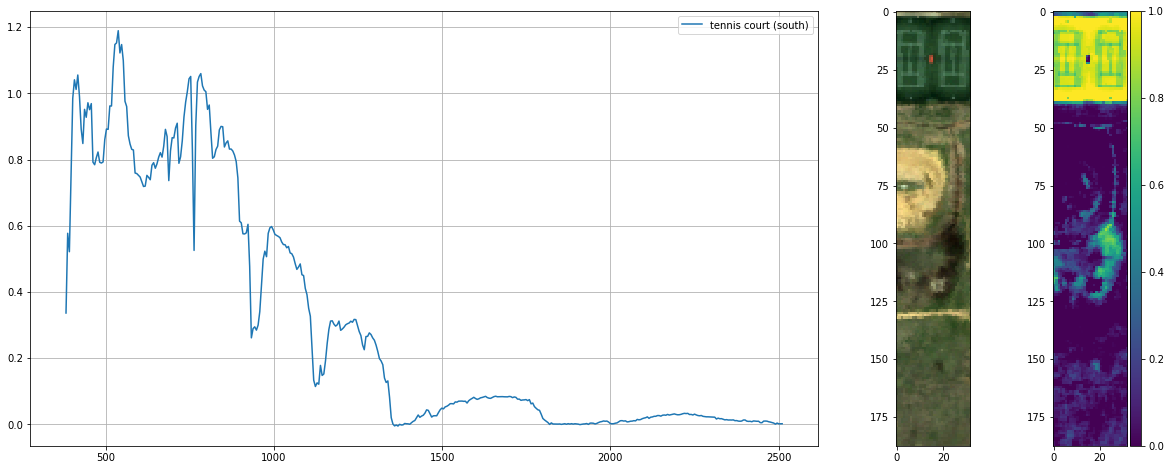

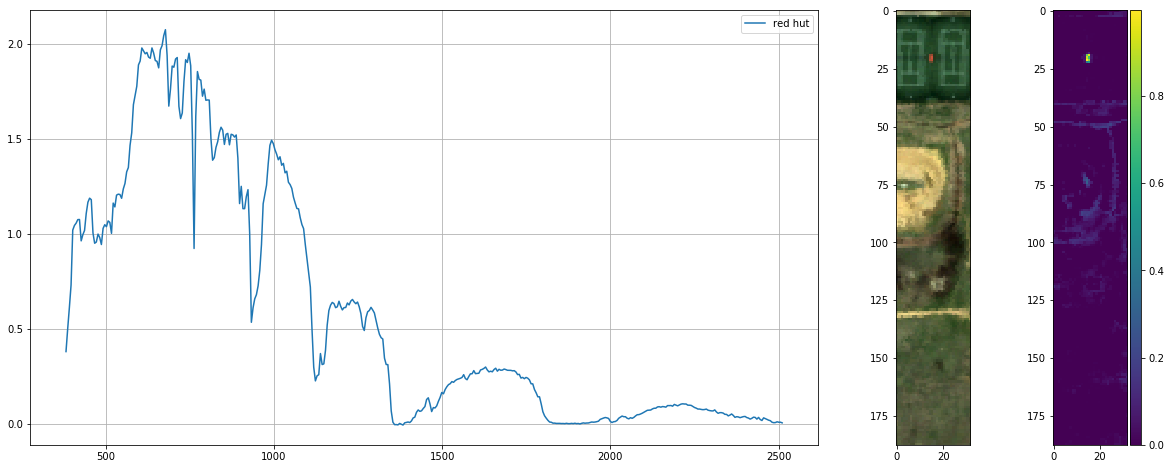

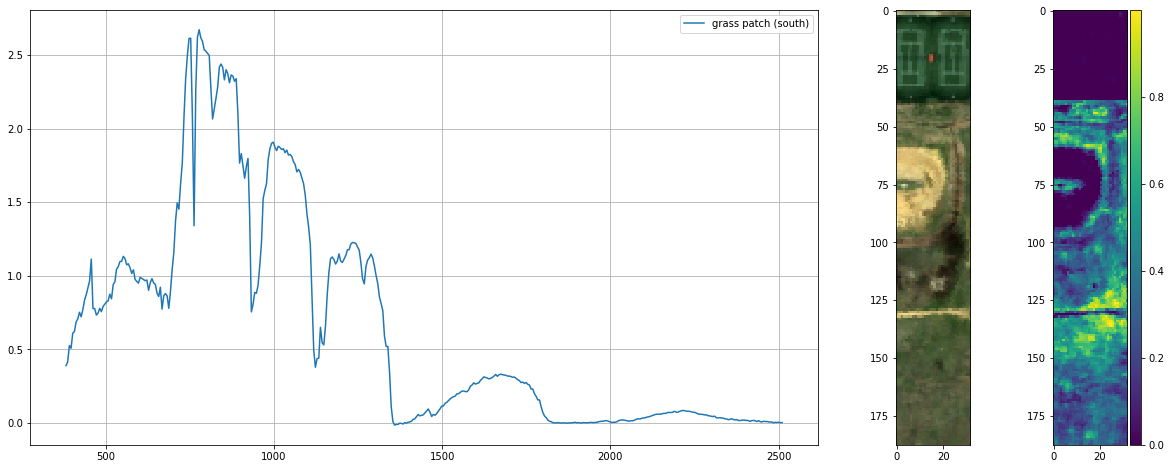

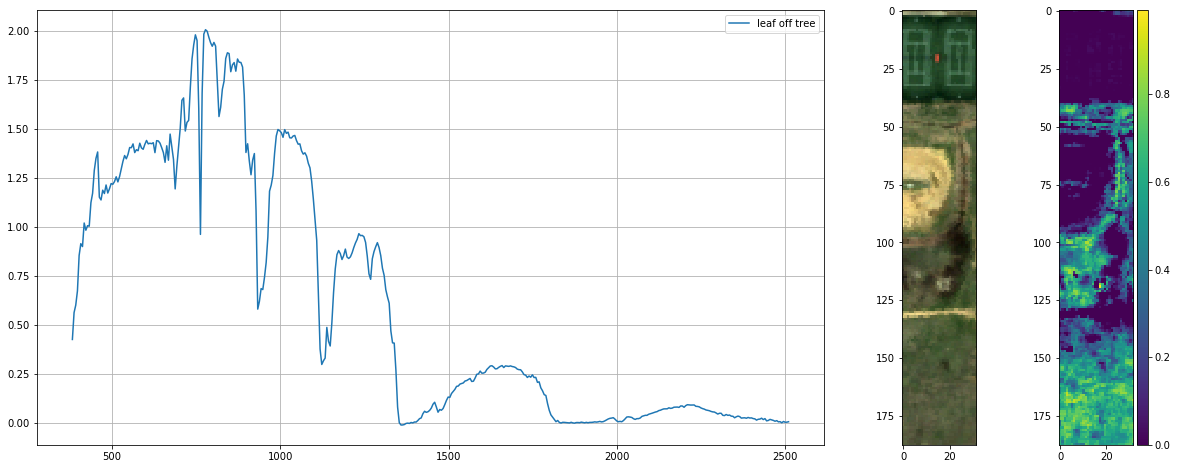

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [40]:
Ue = neon_pt_em
    
# plot them
plt.figure(figsize=(20,10))
for i, em in enumerate(Ue):
    plt.plot(neon_wav, em, label=gdf.comments[i])

plt.title(f'Point Extracted Endmembers from NEON Subset')
plt.legend()
plt.grid(True)
plt.show()

# Plot the abundance maps
am = amap.FCLS()
ab_maps = am.map(neon_sub_cube.values, Ue, normalize=False)

for i,em in enumerate(Ue):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[8, 1, 1]) 

    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(neon_wav, em, label=gdf.comments[i])
    ax0.legend()
    ax0.grid(True)

    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(ab_maps[:,:,i])


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="15%", pad=0.05)

    plt.colorbar(im2, cax=cax)
    plt.show()

print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')

# Try for Headwall

In [126]:
gdf_test = gdf_4326

# create mask datasets for the VNIR and SWIR data separately
ds_vnir = xr.Dataset(coords={'y':y_vnir_ls[0], 'x':x_vnir_ls[0]})
shapes = [(shape, n) for n, shape in enumerate(gdf_test.geometry)]

temp_vnir = []
for i, shape in enumerate(shapes):
    
    try:
        ds_vnir['aoi'] = rasterize([shape], ds_vnir.coords)
        ds_vnir['aoi'] = ds_vnir.aoi*0 + 1
        example_vnir = ds_vnir.aoi * xarr_VNIR_ls[0]

        val_y, val_x = np.where(ds_vnir.aoi==1)
        u_y = np.unique(val_y)
        u_x = np.unique(val_x)
        ex_vnir = example_vnir.sel(y=y_vnir_ls[0][val_y], x=x_vnir_ls[0][val_x])

        # cut off the VNIR if provided
        w_cutoff = 896
        if w_cutoff > 0:
            b_cutoff = np.where(ex_vnir.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
            ex_vnir = ex_vnir.sel(band=slice(0, b_cutoff))

        
        if ex_vnir.shape[0] == 0:
            temp_vnir.append(np.zeros((ex_vnir.shape[-1])))
        else:
            temp_vnir.append(np.squeeze(ex_vnir))
    
    except Exception as e:
        print(e)
        print(val_y, val_x)
        print(f'shape {i} is not in VNIR file')

vnir_stack = np.vstack(temp_vnir)

# SWIR
ds_swir = xr.Dataset(coords={'y':y_swir_ls[0], 'x':x_swir_ls[0]})
shapes = [(shape, n) for n, shape in enumerate(gdf_test.geometry)]

temp_swir = []
for shape in shapes:
    
    try:
        ds_swir['aoi'] = rasterize([shape], ds_swir.coords)
        ds_swir['aoi'] = ds_swir.aoi*0 + 1
        example_swir = ds_swir.aoi * xarr_SWIR_ls[0]

        val_y, val_x = np.where(ds_swir.aoi==1)
        u_y = np.unique(val_y)
        u_x = np.unique(val_x)
        ex_swir = example_swir.sel(y=y_swir_ls[0][val_y], x=x_swir_ls[0][val_x])

        if ex_swir.shape[0] == 0:
            temp_swir.append(np.zeros((ex_swir.shape[-1])))
        else:
            temp_swir.append(np.squeeze(ex_swir))
    except:
        print('shape is not in SWIR file')

swir_stack = np.vstack(temp_swir)

# concatenate the data
full_ex = np.hstack((vnir_stack, swir_stack))


# concatenate the wavelength vectors
full_wav = np.concatenate((ex_vnir.coords['wavelength'].values, ex_swir.coords['wavelength'].values))
full_wav = np.unique(full_wav)

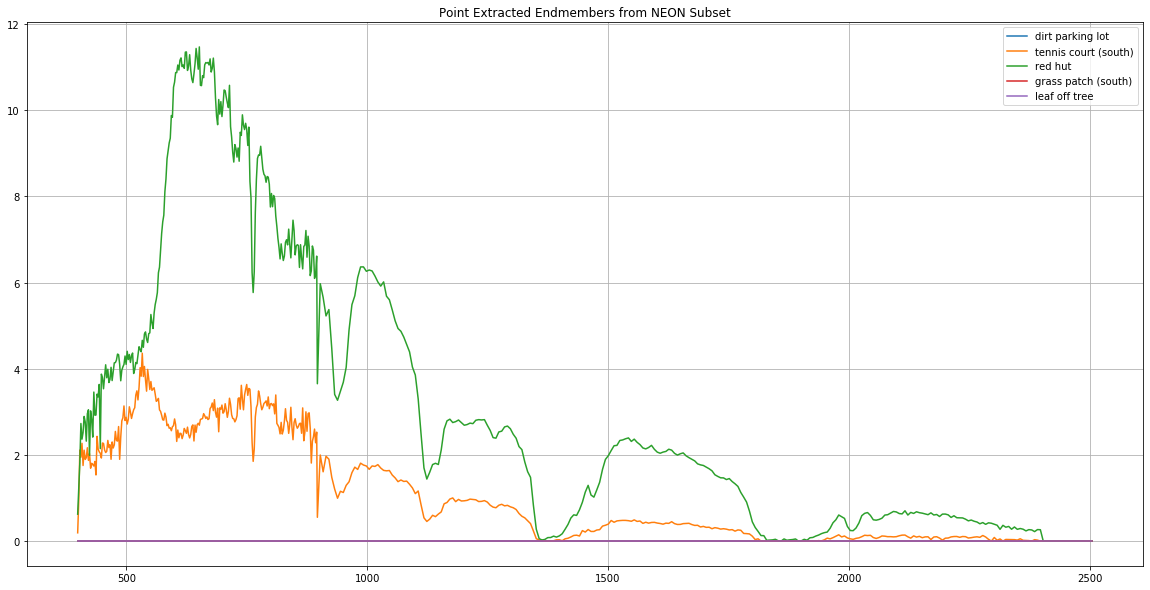

In [130]:
Ue_hw = full_ex
# plot them
plt.figure(figsize=(20,10))
for i, em in enumerate(Ue_hw):
    plt.plot(full_wav, em, label=gdf.comments[i])

plt.title(f'Point Extracted Endmembers from NEON Subset')
plt.legend()
plt.grid(True)
plt.show()

In [132]:
# Plot the abundance maps... need to concatenate the headwall VNIR and SWIR files with same band cut off first. Ouch.

# scribbles


In [40]:
# need to update helper functions to do this processing if geometries are POINTS
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(ex_neon)
    
# ex_neon.shape, ds_neon['aoi'].shape, example_neon.shape

In [50]:
from shapely.geometry.point import Point
type(gdf.geometry[0]) is Point

True

In [ ]:
hw_wav_ls, full_hw_ls = [], []
for xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):
    
    ## do the extraction
    hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                    (xarr_SWIR, x_swir, y_swir), 
                                                                    pt_df_hw,
                                                                    w_cutoff = 896) #896 is start of SWIR wavelength

    full_wav, full_ex = hw_arrs
    
    hw_wav_ls.append(full_wav)
    full_hw_ls.append(full_ex)

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)